In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importing params

In [17]:
keypara_pd = pd.read_csv( 'keypara_pd.csv')
keypara_pd = keypara_pd.drop(columns = ['Unnamed: 0'])

In [18]:
keypara_pd

,Fe_H,T_eff,log_g,a_Fe
0,-0.788,5992,4.222,0.275
1,-0.667,5970,4.383,0.175
2,-0.097,5813,4.339,0.104
3,-0.247,5838,4.492,0.250
4,-1.335,5799,2.306,0.148
...,...,...,...,...
46137,-0.807,5871,4.125,0.279
46138,-0.653,4370,4.527,0.099
46139,-0.676,5231,4.445,0.332
46140,-0.276,4409,4.475,0.098


## sampling 100 points

In [23]:
test_pd = keypara_pd.sample(100)
test_pd

,Fe_H,T_eff,log_g,a_Fe
41207,0.007,5179,3.963,0.053
2327,-0.169,5543,4.487,0.166
39930,-0.737,6018,3.934,0.333
25045,-0.467,5826,4.243,0.248
19967,-0.551,4350,4.459,0.086
...,...,...,...,...
10489,-0.938,6012,4.268,0.195
36836,-1.524,7100,3.894,0.222
22792,-0.949,5976,4.363,0.298
31250,-1.840,7834,4.428,0.255


# ConvecHull

In [25]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [194]:
def get_hull(points):
    hull = ConvexHull(points)
    return hull

def plot_hull(points, ax = plt):
    hull = ConvexHull(points)
    ax.scatter(points[:,0],points[:,1], color = 'teal' , s = 0.1)
    for simplex in hull.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], 'k-')
    return hull

def plot_hull_simlices(hull, ax = plt):
    for simplex in hull.simplices:
        ax.plot(points[simplex, 0], points[simplex, 1], 'k-')

In [195]:
para0 = 'Fe_H'
para1 = 'T_eff'
points = keypara_pd[[para0, para1]].values
hull_FeTe = get_hull(points)

# Check in hull

In [196]:
def isinhull(point, hull, tolerance=1e-12):
    for eq in hull.equations:
        if np.dot(eq[:-1], point) + eq[-1] > tolerance: return False
    return True

In [197]:
isinhull([-3., 7000], hull)

True

In [198]:
isinhull([-3., 4000], hull)

False

# Rejection Sampling

In [199]:
from random import uniform

In [338]:
def get_box(points):
    bnds = np.zeros([2,2])
    bnds[:,0] = points.min(axis = 0)
    bnds[:,1] = points.max(axis = 0)
    return bnds

def get_sample(bnds):
    return [uniform(bnds[0][0], bnds[0][1]), uniform(bnds[1][0], bnds[1][1])]    

def get_inhull_sample(points, N_sample = 10):
    bnds = get_box(points)
    hull = get_hull(points)
    inhull_samples = np.zeros([N_sample, 2])
    i = 0
    while i < N_sample:
        sample = get_sample(bnds)
        if isinhull(sample, hull):
            inhull_samples[i] = sample
            i +=1
    return inhull_samples

def plot_inhull_sample(points,inhull_samples = None, N_sample = 10):
    if inhull_samples is not None:
        N_sample = len(inhull_samples)
    else:
        inhull_samples = get_inhull_sample(points, N_sample)
    fig, (ax0, ax1) = plt.subplots(1,2,figsize = (16,5))
    hull =plot_hull(points, ax0)
    plot_hull_simlices(hull, ax1)
    ax1.scatter(inhull_samples[:,0], inhull_samples[:,1], c = 'aqua', s = 0.1)
    fig.suptitle(f' {N_sample} uniformly sampled points in convex hull from box')

In [336]:
inhull_samples = get_inhull_sample(points, 10000)

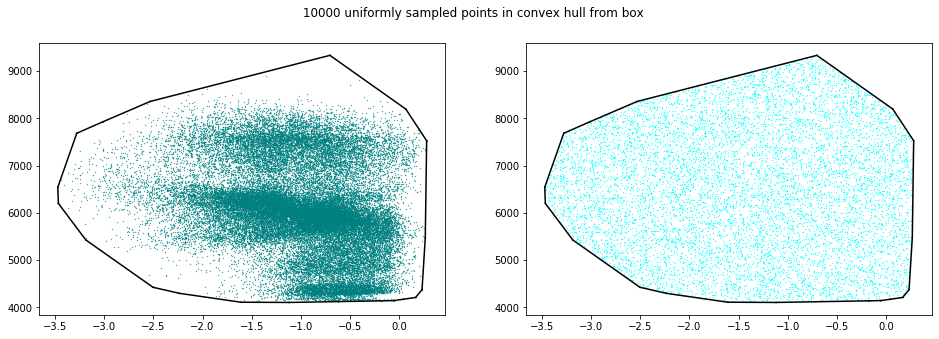

In [339]:
plot_inhull_sample(points,inhull_samples)
plt.savefig('ConvexHull.png', transparent = False)

# GMM (Gaussian mixture models)

In [215]:
from sklearn.mixture import GaussianMixture as GMM


In [233]:
def get_gmm(X, n_comp, ax= plt):
    gmm = GMM(n_comp).fit(X)
    labels = gmm.predict(X)
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=0.1, cmap='viridis')
    return gmm, labels

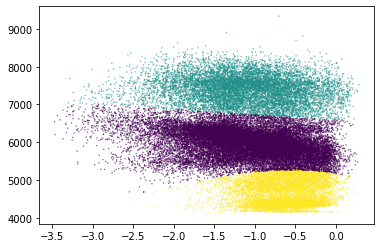

In [249]:
n_comp = 3
gmm, labels = get_gmm(points, n_comp)

In [323]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
#     ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, labels, ax=plt):
#     ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=0.1, cmap='viridis', zorder=2)
#     ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, ax = ax, alpha=w * w_factor)
        
def plot_gmm1(gmm, X, labels, ax=plt):
#     ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=0.01, cmap='viridis', zorder=2)
#     ax.axis('equal')
    w_factor = 1 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, ax = ax, alpha=w * w_factor)

def plot_gmm2(gmm, X, labels, ax=plt):
    ax = ax or plt.gca()
#     ax.scatter(X[:, 0], X[:, 1], c=labels, s=0.01, cmap='viridis', zorder=2)
#     ax.axis('equal')
#     w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        ax = ax or plt.gca()
        draw_ellipse(pos, covar, ax = ax, alpha=w)

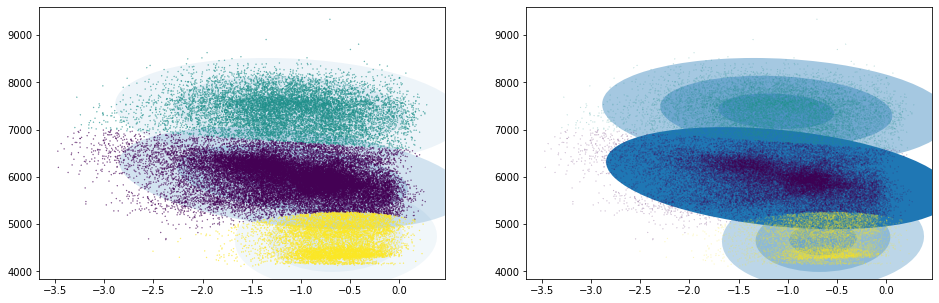

In [256]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize = (16,5))
plot_gmm(gmm, points, labels, ax0)
plot_gmm1(gmm, points, labels, ax1)
# plt.savefig('GMM.png', transparent = False)

# Rejection Sampling from GMM

In [280]:
import random

In [273]:
x,y = np.random.multivariate_normal(gmm.means_[0], a, 500).T

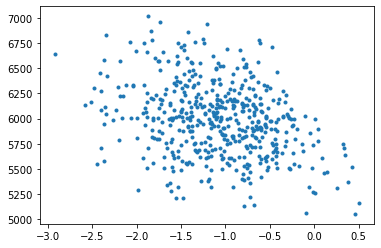

In [275]:
plt.plot(x,y, '.')

In [331]:
bnds[0]

array([-3.473,  0.282])

In [330]:
bnds = get_box(points)

(4104.0, 9334.0)

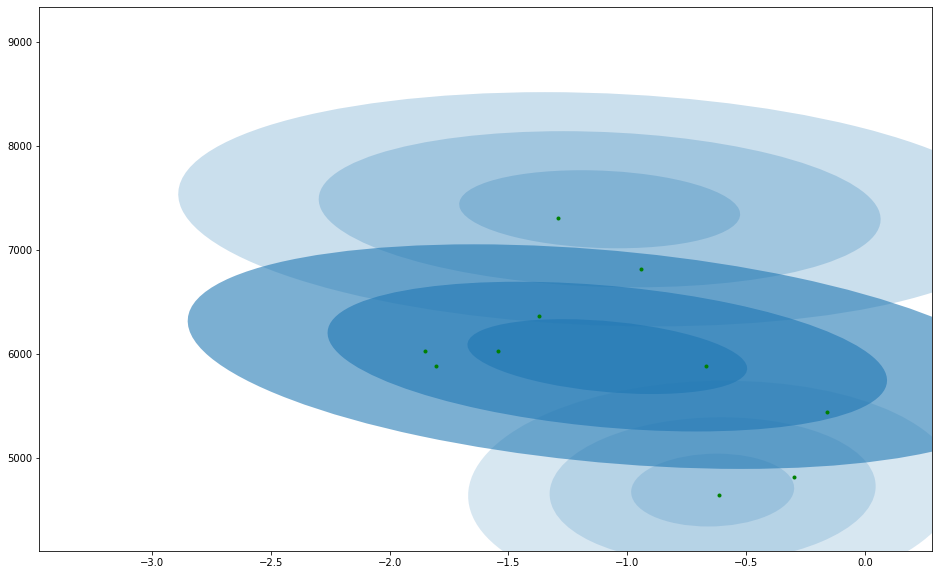

In [332]:
k = 10
GMM_idx = random.choices([0,1,2], gmm.weights_, k=k) 
# N_gmms = (gmm.weights_ * k).round().astype(int)
# assert np.sum(N_gmms) == k
# GMM_samples = np.zeros([k,2])
xs = []
ys = []
for idx in range(k):
    N_gmm = N_gmms[idx]
    x,y = np.random.multivariate_normal(gmm.means_[idx], gmm.covariances_[idx] , N_gmm).T   
    xs.extend(x)
    ys.extend(y)
plt.figure(figsize =(16,10))
plt.plot(xs,ys, 'g.')
plot_gmm2(gmm, points, labels, plt.gca())
plt.xlim(bnds[0])
plt.ylim(bnds[1])


In [287]:
np.random.multivariate_normal(gmm.means_[0], a, 1)[0]

array([-1.67299924e+00,  6.11130228e+03])

In [276]:
gmm.__dict__


{'n_components': 3,
 'tol': 0.001,
 'reg_covar': 1e-06,
 'max_iter': 100,
 'n_init': 1,
 'init_params': 'kmeans',
 'random_state': None,
 'warm_start': False,
 'verbose': 0,
 'verbose_interval': 10,
 'covariance_type': 'full',
 'weights_init': None,
 'means_init': None,
 'precisions_init': None,
 'converged_': True,
 'weights_': array([0.58941481, 0.23466309, 0.17592209]),
 'means_': array([[-1.08415091e+00,  5.97231002e+03],
        [-1.11624796e+00,  7.39007146e+03],
        [-6.41107840e-01,  4.68840637e+03]]),
 'covariances_': array([[[ 3.46048296e-01, -6.72962023e+01],
         [-6.72962023e+01,  1.29703363e+05]],
 
        [[ 3.49082256e-01, -2.87145712e+01],
         [-2.87145712e+01,  1.41013064e+05]],
 
        [[ 1.17505819e-01,  6.32953904e+00],
         [ 6.32953904e+00,  1.22738282e+05]]]),
 'precisions_cholesky_': array([[[ 1.69993236e+00,  5.69474570e-01],
         [ 0.00000000e+00,  2.92833322e-03]],
 
        [[ 1.69252898e+00,  2.20908757e-01],
         [ 0.00000000e+